勝率 p = 0.51, オッズ b = 2.0, ラウンド数 T = 500, モンテカルロ本数 N = 20000
ケリー最適比率 f* = 0.0200


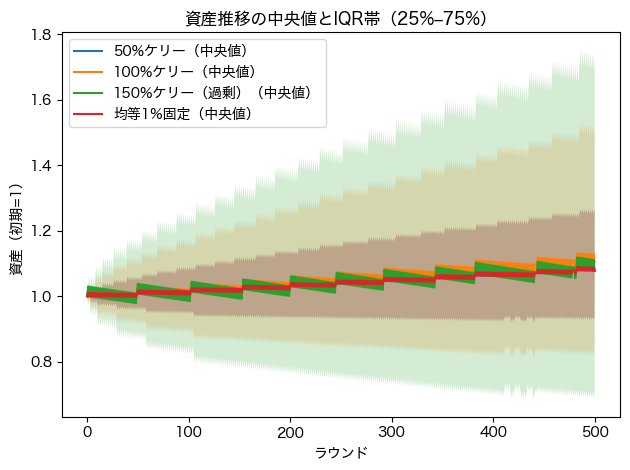

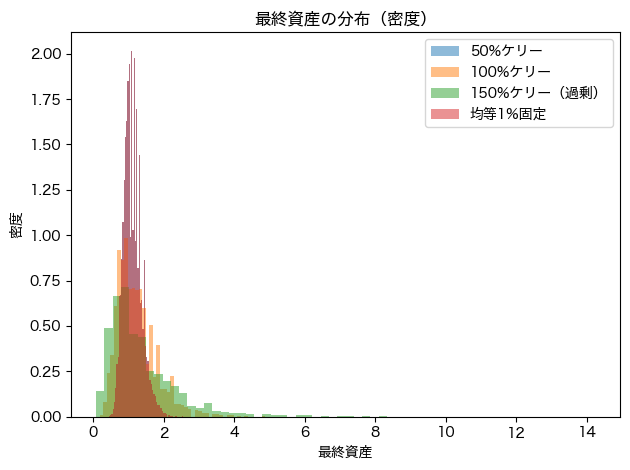

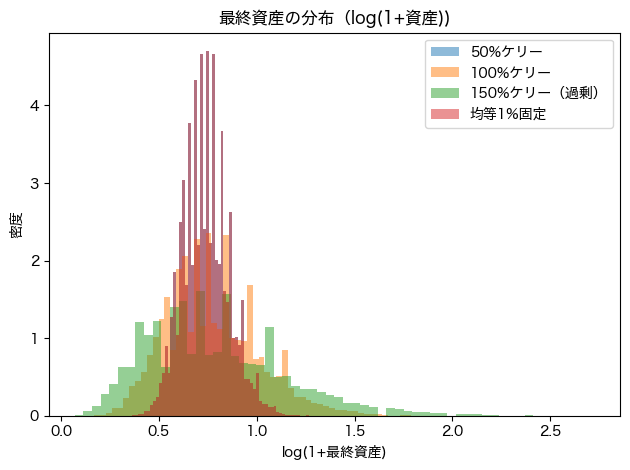

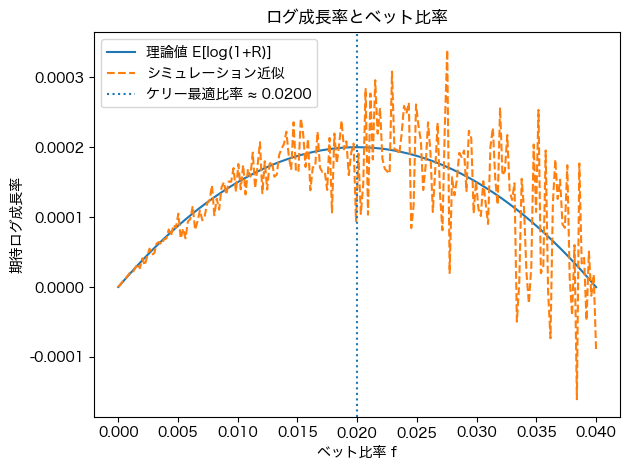

OSError: Cannot save file into a non-existent directory: '/mnt/data'

In [6]:
# Improved Kelly Criterion Monte Carlo Simulation (vectorized, Japanese-safe fonts, risk metrics)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# ===== 日本語フォント（macOS想定） =====
mpl.rcParams['font.family'] = 'Hiragino Sans'
mpl.rcParams['axes.unicode_minus'] = False  # 负号の文字化け回避

# ===== 乱数生成器 =====
rng = np.random.default_rng(42)

# ===== パラメータ（ユーザー指定値） =====
p = 0.51       # 勝率
b = 1.0          # オッズ（勝つと+f*b、負けると-f）
n_rounds = 500   # ラウンド数
n_paths = 20000  # モンテカルロ本数
initial_wealth = 1.0
print(f"勝率 p = {p}, オッズ b = {b+1}, ラウンド数 T = {n_rounds}, モンテカルロ本数 N = {n_paths}")
# ===== ケリー比率 =====
f_kelly = (b * p - (1 - p)) / b  # b=1のとき 2p-1

print(f"ケリー最適比率 f* = {f_kelly:.4f}")
strategies = {
    "0%（ベットなし）": 0.0,
    "50%ケリー": 0.5 * f_kelly,
    "100%ケリー": f_kelly,
    "150%ケリー（過剰）": 1.5 * f_kelly,
    "均等1%固定": 0.01,
}

# ===== ベクトル化したシミュレーション =====
# 勝敗行列（True=勝ち） shape: (n_paths, n_rounds)
wins = rng.uniform(size=(n_paths, n_rounds)) < p

def simulate_vectorized(fraction: float) -> np.ndarray:
    """
    与えられた比率でn_paths本の資産推移（複利）を同時に計算して返す。
    戻り値: shape=(n_paths, n_rounds+1) 先頭列が初期資産
    """
    # 破綻防止（log未定義を避ける安全側クリップ）
    f = float(np.clip(fraction, -0.99, 0.99))
    # リターン行列 R: 勝ちなら f*b、負けなら -f
    R = np.where(wins, f * b, -f)
    # 複利を一括計算：資産=初期*累積(1+R)
    wealth = np.empty((n_paths, n_rounds + 1), dtype=np.float64)
    wealth[:, 0] = initial_wealth
    # 累積積を列方向に計算
    wealth[:, 1:] = np.cumprod(1.0 + R, axis=1) * initial_wealth
    return wealth

def max_drawdown(wealth_paths: np.ndarray) -> np.ndarray:
    """
    最大ドローダウン（比率）を各パスごとに返す。shape=(n_paths,)
    """
    peak = np.maximum.accumulate(wealth_paths, axis=1)
    dd = 1.0 - (wealth_paths / peak)
    return dd.max(axis=1)

# ===== 実行 =====
results = {}
summaries = []
for label, f in strategies.items():
    W = simulate_vectorized(f)
    final_wealth = W[:, -1]
    mdd = max_drawdown(W)
    # 追加リスク指標
    ruin50 = (W.min(axis=1) <= initial_wealth * 0.5).mean()   # 50%割れ経験確率
    ruin80 = (W.min(axis=1) <= initial_wealth * 0.2).mean()   # 80%割れ経験確率
    neg_final = (final_wealth < initial_wealth).mean()        # 最終損失確率

    summaries.append({
        "戦略": label,
        "採用比率f": f,
        "勝率p": p,
        "オッズb": b,
        "ケリー比率": f_kelly,
        "平均最終資産": float(final_wealth.mean()),
        "中央値最終資産": float(np.median(final_wealth)),
        "5%分位最終資産": float(np.percentile(final_wealth, 5)),
        "95%分位最終資産": float(np.percentile(final_wealth, 95)),
        "平均最大DD": float(mdd.mean()),
        "中央値最大DD": float(np.median(mdd)),
        "DD>50%の確率": float((mdd > 0.5).mean()),
        "資産<初期の確率": float(neg_final),
        "途中50%割れ確率": float(ruin50),
        "途中80%割れ確率": float(ruin80),
    })
    results[label] = {"paths": W, "final": final_wealth, "mdd": mdd}

summary_df = pd.DataFrame(summaries)
summary_df = summary_df[[
    "戦略","採用比率f","勝率p","オッズb","ケリー比率",
    "平均最終資産","中央値最終資産","5%分位最終資産","95%分位最終資産",
    "平均最大DD","中央値最大DD","DD>50%の確率","資産<初期の確率",
    "途中50%割れ確率","途中80%割れ確率"
]].sort_values("採用比率f")

# 丸め表示用
summary_show = summary_df.copy()
for c in summary_show.columns.drop("戦略"):
    summary_show[c] = summary_show[c].astype(float).round(4)

# ===== 可視化 =====
# (1) タイムシリーズ：中央値とIQR（25%-75%）帯域
def plot_quantile_bands(labels, q_low=25, q_high=75):
    plt.figure()
    T = n_rounds
    x = np.arange(T + 1)
    for label in labels:
        W = results[label]["paths"]
        q25 = np.percentile(W, q_low, axis=0)
        q50 = np.percentile(W, 50, axis=0)
        q75 = np.percentile(W, q_high, axis=0)
        plt.plot(x, q50, label=f"{label}（中央値）")
        plt.fill_between(x, q25, q75, alpha=0.2)
    plt.title("資産推移の中央値とIQR帯（25%–75%）")
    plt.xlabel("ラウンド")
    plt.ylabel("資産（初期=1）")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_quantile_bands(["50%ケリー","100%ケリー","150%ケリー（過剰）","均等1%固定"])

# (2) 最終資産の分布（対数スケールも参考）
plt.figure()
bins = 60
for label in ["50%ケリー","100%ケリー","150%ケリー（過剰）","均等1%固定"]:
    plt.hist(results[label]["final"], bins=bins, density=True, alpha=0.5, label=label)
plt.title("最終資産の分布（密度）")
plt.xlabel("最終資産")
plt.ylabel("密度")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
for label in ["50%ケリー","100%ケリー","150%ケリー（過剰）","均等1%固定"]:
    plt.hist(np.log1p(results[label]["final"]), bins=bins, density=True, alpha=0.5, label=label)
plt.title("最終資産の分布（log(1+資産))")
plt.xlabel("log(1+最終資産)")
plt.ylabel("密度")
plt.legend()
plt.tight_layout()
plt.show()

# (3) ログ成長率（理論 vs シミュレーション）
def log_growth(f):
    q = 1.0 - p
    if f <= -0.99 or f >= 0.99:
        return np.nan
    return p*np.log(1 + f*b) + q*np.log(1 - f)

f_grid = np.linspace(0, min(0.99, f_kelly*2.0), 200)
g_theory = np.array([log_growth(f) for f in f_grid])

def sim_log_growth(f, trials=200_000):
    # 試行ベクトル化
    wins_local = rng.uniform(size=trials) < p
    r = np.where(wins_local, f*b, -f)
    return float(np.mean(np.log1p(r)))

g_sim = np.array([sim_log_growth(float(f)) for f in f_grid])

plt.figure()
plt.plot(f_grid, g_theory, label="理論値 E[log(1+R)]")
plt.plot(f_grid, g_sim, linestyle="--", label="シミュレーション近似")
plt.axvline(f_kelly, linestyle=":", label=f"ケリー最適比率 ≈ {f_kelly:.4f}")
plt.title("ログ成長率とベット比率")
plt.xlabel("ベット比率 f")
plt.ylabel("期待ログ成長率")
plt.legend()
plt.tight_layout()
plt.show()

# ===== 出力保存 =====
csv_path = "/mnt/data/kelly_summary_p060_T100_N20000.csv"
summary_df.to_csv(csv_path, index=False)

csv_path
